In [45]:
#Importation des bibliothèques
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import datetime as dt
from datetime import datetime, timedelta

I. Récupération et formatage des données

In [46]:
#Initialisation 
endpoint = 'https://min-api.cryptocompare.com/data/histoday'
#Initialisation de la date d'aujourd'hui
today = dt.date.today().strftime('%Y-%m-%d')
end = today
#Initialisation du nombre de jours à télécharger
limit = 2000
#Formatage de la date au format adapté à l'API
end_timestamp = int(dt.datetime.strptime(end, '%Y-%m-%d').timestamp())
# Requête avec les dates spécifiques (Nous utiliserons les données du Bitcoin)
res = requests.get(f'{endpoint}?fsym=BTC&tsym=EUR&limit={limit}&toTs={end_timestamp}')
df = pd.DataFrame(json.loads(res.content)['Data'])
df = df.set_index('time')
df.index = pd.to_datetime(df.index, unit='s')
# Supprimer les données au-delà de la date de début
df.head(5)

,high,low,open,volumefrom,volumeto,close,conversionType,conversionSymbol
time,,,,,,,,
2018-08-23,5681.22,5483.01,5490.65,10047.12,56099333.41,5656.70,direct,
2018-08-24,5785.98,5578.51,5657.22,8416.09,47724236.71,5764.76,direct,
2018-08-25,5839.70,5735.02,5763.86,5106.32,29537827.80,5794.06,direct,
2018-08-26,5822.57,5670.36,5794.06,4616.33,26536977.11,5774.14,direct,
2018-08-27,5920.68,5731.88,5770.35,8847.14,51241309.09,5906.56,direct,


In [3]:
#suppression des 2 colonnes string
df = df.drop(['conversionType', 'conversionSymbol'], axis=1)
df.tail(5)

,high,low,open,volumefrom,volumeto,close
time,,,,,,
2024-02-09,44613.33,42007.74,42035.07,3892.30,1.696114e+08,43558.57
2024-02-10,44481.18,43252.84,43558.57,1402.92,6.141105e+07,44119.31
2024-02-11,44730.90,43966.42,44119.31,1177.53,5.236639e+07,44595.42
2024-02-12,46642.42,44210.10,44595.42,3611.23,1.647042e+08,46293.88
2024-02-13,46688.23,45115.17,46293.88,2804.11,1.290293e+08,46181.19


In [4]:
# Compter les valeurs manquantes par colonne
missing_values = df.isnull().sum()
print(missing_values)
# Calculer le nombre total de valeurs manquantes
total_missing = missing_values.sum()
print("Nombre total de valeurs manquantes :", total_missing)
# Gestion des données manquantes
start_date = df.index.min()
end_date = df.index.max()
all_dates = pd.date_range(start=start_date, end=end_date, freq='D')
df = df.reindex(all_dates)
df['close'] = df['close'].interpolate()

high          0
low           0
open          0
volumefrom    0
volumeto      0
close         0
dtype: int64
Nombre total de valeurs manquantes : 0


In [5]:
# Modification du format de l'index des dates
df.index = df.index.strftime('%d-%m-%Y')
# Affichage des cinq premières lignes avec le nouvel index
df.head(5)

,high,low,open,volumefrom,volumeto,close
23-08-2018,5681.22,5483.01,5490.65,10047.12,56099333.41,5656.70
24-08-2018,5785.98,5578.51,5657.22,8416.09,47724236.71,5764.76
25-08-2018,5839.70,5735.02,5763.86,5106.32,29537827.80,5794.06
26-08-2018,5822.57,5670.36,5794.06,4616.33,26536977.11,5774.14
27-08-2018,5920.68,5731.88,5770.35,8847.14,51241309.09,5906.56


II. Analyse et visualisations de données

In [6]:
#Analyse descriptive du dataset
df.describe()

,high,low,open,volumefrom,volumeto,close
count,2001.000000,2001.000000,2001.000000,2001.000000,2.001000e+03,2001.00000
mean,21675.002779,20653.519485,21179.728661,9392.684623,1.825852e+08,21200.09903
std,14508.632373,13783.201593,14163.504025,8282.553311,2.273111e+08,14170.25035
min,2877.610000,2794.750000,2848.240000,486.020000,1.134218e+07,2848.24000
25%,8283.470000,8012.150000,8158.750000,4376.770000,5.568200e+07,8164.24000
50%,20508.850000,19696.660000,20156.820000,7552.320000,1.017720e+08,20170.36000
75%,33020.130000,30912.030000,32280.230000,11780.690000,2.175615e+08,32287.68000
max,59647.190000,57244.070000,58276.660000,141790.660000,2.980086e+09,58276.66000


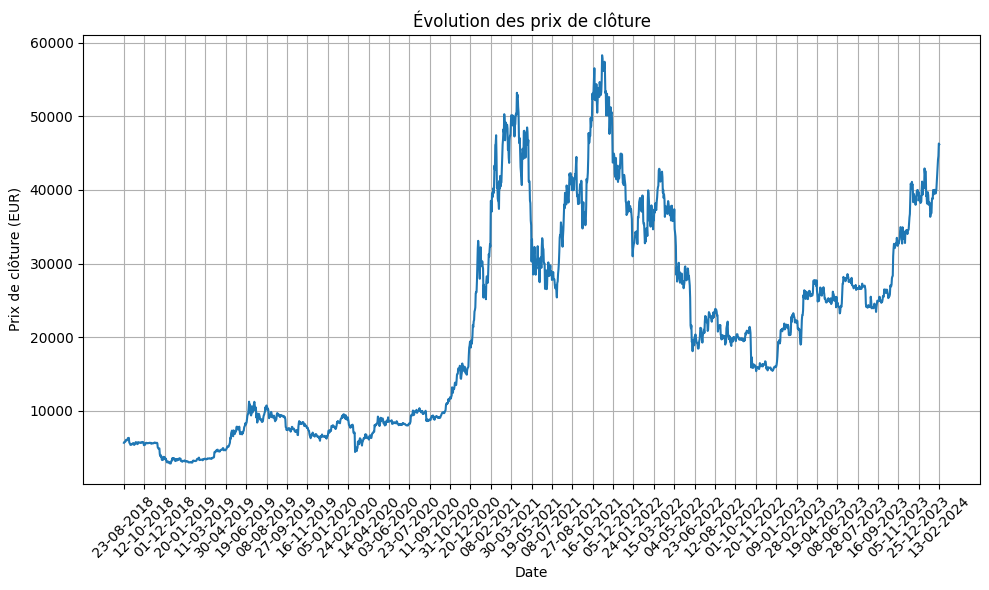

In [7]:
#Visualisation des prix de clôture avec les dates sur l'axe des abscisses
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['close'], label='Prix de clôture')
plt.title('Évolution des prix de clôture')
plt.xlabel('Date')
plt.ylabel('Prix de clôture (EUR)')
plt.grid(True)
#Formater les dates sur l'axe x
plt.xticks(df.index[::50], rotation=45)  # Récupère toutes les 50 dates pour éviter la surcharge
plt.tight_layout()  # Ajustement pour éviter que les dates se chevauchent
plt.show()


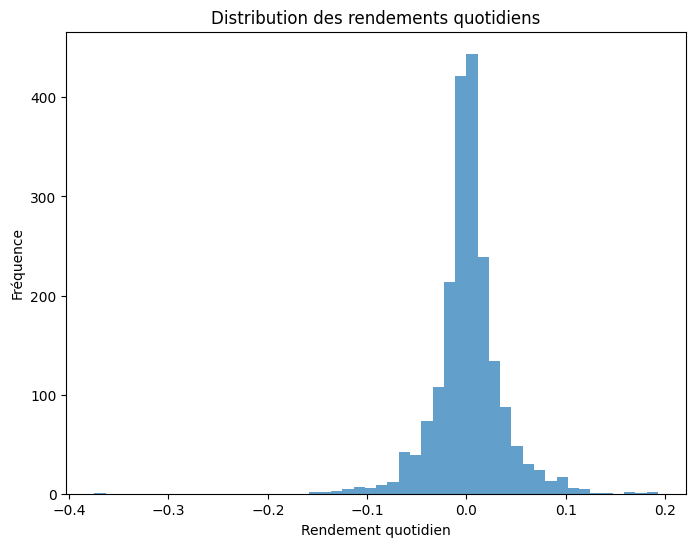

Volatilité des prix : 0.034837667637804236


In [8]:
# Calcul de l'écart-type des rendements quotidiens
daily_returns = df['close'].pct_change()
volatility = daily_returns.std()
# Histogramme des rendements quotidiens
plt.figure(figsize=(8, 6))
plt.hist(daily_returns.dropna(), bins=50, alpha=0.7)
plt.title('Distribution des rendements quotidiens')
plt.xlabel('Rendement quotidien')
plt.ylabel('Fréquence')
plt.show()
print(f"Volatilité des prix : {volatility}")



In [9]:
#Préparation des données de moyenne mobile à 10 et 30 jours (Moving Average)
ma10 = df.close.rolling(10).mean()
ma30 = df.close.rolling(30).mean()

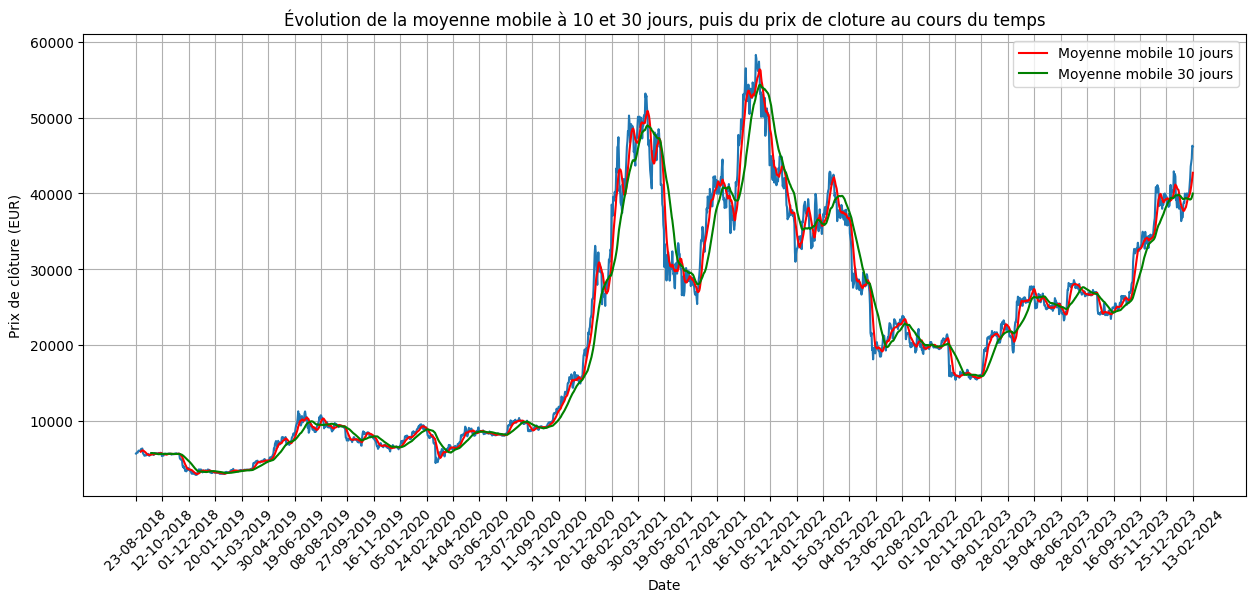

In [15]:
#Visualisation de la courbe de la moyenne mobile à 10 et 30 jours et du prix de clôture en fonction du temps
plt.figure(figsize=(15,6))
plt.plot(df.close)
plt.plot(ma10, 'r', label='Moyenne mobile 10 jours')  
plt.plot(ma30, 'g', label='Moyenne mobile 30 jours')  
plt.title('Évolution de la moyenne mobile à 10 et 30 jours, puis du prix de cloture au cours du temps')
plt.xticks(df.index[::50], rotation=45)  
plt.xlabel('Date')
plt.ylabel('Prix de clôture (EUR)')
plt.legend()
plt.grid(True)

III. Division des données

3.1. Division en Training set et Testing set

In [16]:
#Réinitialisation des index
df=df.reset_index()
df.head()

,index,high,low,open,volumefrom,volumeto,close
0,23-08-2018,5681.22,5483.01,5490.65,10047.12,56099333.41,5656.70
1,24-08-2018,5785.98,5578.51,5657.22,8416.09,47724236.71,5764.76
2,25-08-2018,5839.70,5735.02,5763.86,5106.32,29537827.80,5794.06
3,26-08-2018,5822.57,5670.36,5794.06,4616.33,26536977.11,5774.14
4,27-08-2018,5920.68,5731.88,5770.35,8847.14,51241309.09,5906.56


In [17]:
# Calcul de l'index pour diviser les données (70% pour l'entraînement, 30% pour le test)
train_size = 0.7
split_index = int(len(df) * train_size)
# Séparation des données en ensembles d'entraînement et de test
df_training = pd.DataFrame(df['close'][:split_index])  # Données d'entraînement (70%)
df_testing = pd.DataFrame(df['close'][split_index:])   # Données de test (30%)
# Affichage des tailles des ensembles
print("Taille de l'ensemble d'entraînement :", df_training.shape)
print("Taille de l'ensemble de test :", df_testing.shape)

Taille de l'ensemble d'entraînement : (1400, 1)
Taille de l'ensemble de test : (601, 1)


In [18]:
df_training.tail(3)

,close
1397,19544.56
1398,19664.24
1399,18892.95


In [19]:
df_testing.head(3)

,close
1400,20045.78
1401,20102.73
1402,20372.37


3.2. Division en x_train, y_train, x_test, y_test

Données d'entrainement: x_train, y_train 

In [20]:
#Scaling de la Traing Data et transformation en matrice
scaler = MinMaxScaler(feature_range=(0,1))
df_training_array = scaler.fit_transform(df_training)
df_training_array.shape

(1400, 1)

In [21]:
# Modifier la création des ensembles d'entraînement
x_train = []
y_train = []
for i in range(10, df_training_array.shape[0] - 5):  # Ajuster pour prendre en compte les 5 jours suivants
    x_train.append(df_training_array[i-10:i])
    y_train.append(df_training_array[i:i+5, 0])  # Séquence de 5 jours en sortie



In [22]:
#Conversion de x_train et y_train en matrices
x_train, y_train = np.array(x_train), np.array(y_train)
print(x_train.shape)
print(y_train.shape)

(1385, 10, 1)
(1385, 5)


Données de test: x_test, y_test

In [23]:
#Charger les 14 dernières lignes du Training Set pour les ajouter au (début) Testing Set
past_14_days = df_training.tail(14)
#Ajouter les 14 dernières lignes aux Data Frame final du Testing
df_testing = pd.concat([past_14_days, df_testing])
df_testing.shape

(615, 1)

In [24]:
#Scaling pour changer l'échelle du Testing Set à [0-1]
df_testing_array = scaler.fit_transform(df_testing)
df_testing_array.shape

(615, 1)

In [25]:
# Modifier la création des ensembles de test
x_test = []
y_test = []
for i in range(10, df_testing_array.shape[0] - 5):  # Ajuster pour prendre en compte les 5 jours suivants
    x_test.append(df_testing_array[i-10:i])
    y_test.append(df_testing_array[i:i+5, 0])



In [26]:
#Conversion de x_test et y_test en matrices
x_test, y_test = np.array(x_test), np.array(y_test)
print(x_test.shape)
print(y_test.shape)

(600, 10, 1)
(600, 5)


IV. Entrainement d'un modèle LSTM

In [27]:
# Fonction pour construire le modèle LSTM
def build_model(input_shape):
    # Création d'un modèle séquentiel
    model = Sequential()

    # Première couche LSTM avec 50 unités, activation ReLU, retourne des séquences, et input shape correspondant aux données
    model.add(LSTM(units=50, activation='relu', return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))  # Dropout pour régulariser le modèle, évitant le surapprentissage

    # Deuxième couche LSTM avec 60 unités, activation ReLU, retourne des séquences
    model.add(LSTM(units=60, activation='relu', return_sequences=True))
    model.add(Dropout(0.3))  # Dropout pour régulariser le modèle

    # Troisième couche LSTM avec 80 unités, activation ReLU, retourne des séquences
    model.add(LSTM(units=80, activation='relu', return_sequences=True))
    model.add(Dropout(0.4))  # Dropout pour régulariser le modèle

    # Quatrième couche LSTM avec 120 unités, activation ReLU
    model.add(LSTM(units=120, activation='relu'))
    model.add(Dropout(0.5))  # Dropout pour régulariser le modèle

    # Couche Dense (entièrement connectée) avec une unité pour la prédiction
    model.add(Dense(units=5))

    # Retourne le modèle construit
    return model

In [28]:
# Création du modèle en utilisant la fonction build_model
model = build_model(input_shape=(x_train.shape[1], 1))
model.summary()  # Affiche le résumé du modèle pour examiner les paramètres


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 10, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 10, 60)            26640     
                                                                 
 dropout_1 (Dropout)         (None, 10, 60)            0         
                                                                 
 lstm_2 (LSTM)               (None, 10, 80)            45120     
                                                                 
 dropout_2 (Dropout)         (None, 10, 80)            0         
                                                                 
 lstm_3 (LSTM)               (None, 120)               

In [29]:
#Compilation et training du modèle
model.compile(optimizer='adam', loss = 'mean_squared_error')
history=model.fit(x_train, y_train, epochs = 500, validation_split=0.1)

"""Temps d'exécution de la cellule: Environ 7 minutes"""


Epoch 1/500

39/39 [==============================] - 7s 33ms/step - loss: 0.0766 - val_loss: 0.0065
Epoch 2/500
39/39 [==============================] - 1s 17ms/step - loss: 0.0221 - val_loss: 0.0103
Epoch 3/500
39/39 [==============================] - 1s 16ms/step - loss: 0.0129 - val_loss: 0.0058
Epoch 4/500
39/39 [==============================] - 1s 18ms/step - loss: 0.0102 - val_loss: 0.0044
Epoch 5/500
39/39 [==============================] - 1s 23ms/step - loss: 0.0087 - val_loss: 0.0043
Epoch 6/500
39/39 [==============================] - 1s 16ms/step - loss: 0.0084 - val_loss: 0.0044
Epoch 7/500
39/39 [==============================] - 1s 16ms/step - loss: 0.0080 - val_loss: 0.0058
Epoch 8/500
39/39 [==============================] - 1s 16ms/step - loss: 0.0072 - val_loss: 0.0044
Epoch 9/500
39/39 [==============================] - 1s 23ms/step - loss: 0.0074 - val_loss: 0.0067
Epoch 10/500
39/39 [==============================] - 1s 21ms/step - loss: 0.0066 - val_loss: 0.00

"Temps d'exécution de la cellule: Environ 7 minutes"

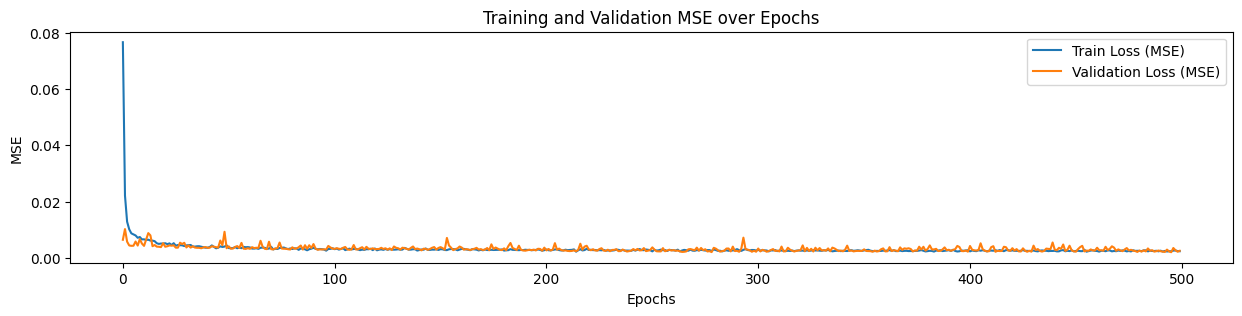

In [30]:
# Affichage de l'historique d'entraînement (MSE)
plt.figure(figsize=(15,3))
plt.plot(history.history['loss'], label='Train Loss (MSE)')
plt.plot(history.history['val_loss'], label='Validation Loss (MSE)')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.title('Training and Validation MSE over Epochs')
plt.show()

V. Enregistrement du modèle

In [31]:
#Enregistrement du modèle
model.save('cryptoforetellmodel.h5')

c:\Users\ngale\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


VI. Évaluation du modèle

In [32]:
#Prédictions pour x_test
y_pred = model.predict(x_test)
y_pred.shape

19/19 [==============================] - 1s 7ms/step


(600, 5)

In [33]:
# Annuler la normalisation pour les prédictions
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 5))  # Ajuster pour les 5 jours prédits
# Annuler la normalisation pour les données de test
y_testing = scaler.inverse_transform(y_test.reshape(-1, 5))  # Ajuster pour les 5 jours de données de test

In [39]:
y_pred[-1],y_testing[-1]

(array([40429.336, 40327.25 , 40308.234, 40285.08 , 40304.676],
       dtype=float32),
 array([42035.07, 43558.57, 44119.31, 44595.42, 46293.88]))

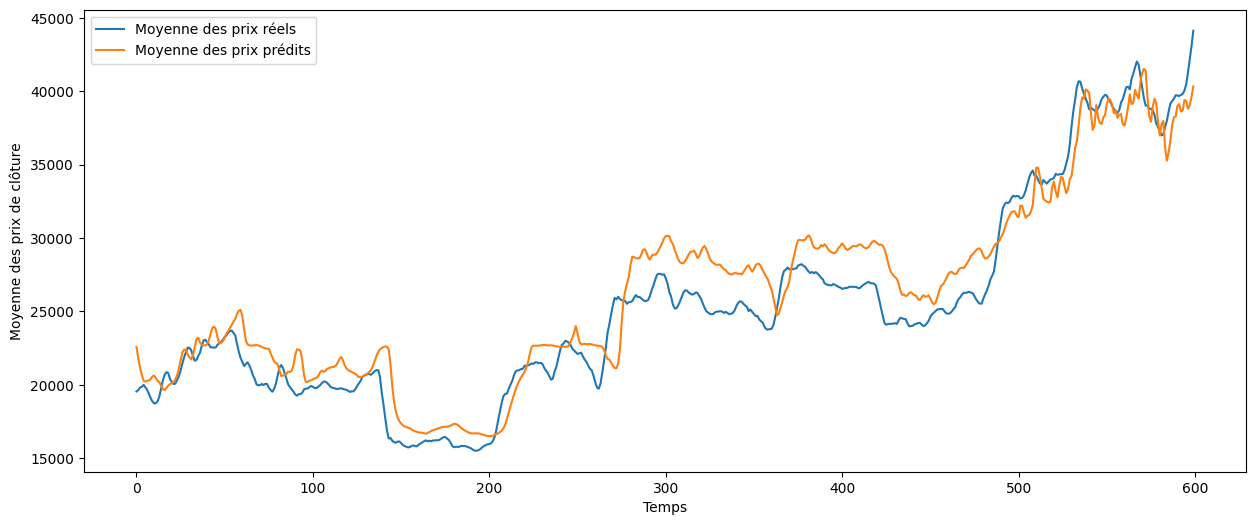

In [40]:
# Calculer la moyenne des prédictions et des valeurs réelles pour chaque jour
mean_pred = np.mean(y_pred, axis=1)
mean_actual = np.mean(y_testing, axis=1)
# Visionner la courbe des moyennes des prédictions du cours de clôture VS la moyenne des cours de clôture réels
fig3 = plt.figure(figsize=(15, 6))
plt.plot(mean_actual, label='Moyenne des prix réels')
plt.plot(mean_pred, label='Moyenne des prix prédits')
plt.xlabel('Temps')
plt.ylabel('Moyenne des prix de clôture')
plt.legend()
plt.show()


In [41]:
# Concaténer y_test[-2:] pour obtenir une seule séquence continue
y_test_last_two = np.concatenate(y_test[-2:])
# Reshape pour avoir la même forme que x_test
new_y_test = y_test_last_two.reshape((1, 10, 1))
# Prédire les 5 prochains jours
pred_next_5_days = model.predict(new_y_test)
pred_next_5_days

1/1 [==============================] - 0s 41ms/step


array([[0.89901817, 0.8944857 , 0.89293563, 0.89129364, 0.8907054 ]],
      dtype=float32)

In [42]:
pred_tomorrow_n = scaler.inverse_transform(pred_next_5_days[-1, :5].reshape(1, -1))
pred_tomorrow_n

array([[43172.293, 43032.184, 42984.266, 42933.508, 42915.324]],
      dtype=float32)

In [44]:

# Date d'aujourd'hui
date_today = datetime.today().strftime('%Y-%m-%d')
print("Le prix de clôture pour aujourd'hui (", date_today, ") est : {:.2f}".format(y_testing[-1][0]))
# Prédictions pour les 5 prochains jours
for i in range(5):
    next_day = datetime.strptime(date_today, '%Y-%m-%d') + timedelta(days=i + 1)
    print("Le prix de clôture prédit pour le jour", next_day.strftime('%Y-%m-%d'), "est : {:.2f}".format(float(pred_tomorrow_n[-1, i])))


Le prix de clôture pour aujourd'hui ( 2024-02-14 ) est : 42035.07
Le prix de clôture prédit pour le jour 2024-02-15 est : 43172.29
Le prix de clôture prédit pour le jour 2024-02-16 est : 43032.18
Le prix de clôture prédit pour le jour 2024-02-17 est : 42984.27
Le prix de clôture prédit pour le jour 2024-02-18 est : 42933.51
Le prix de clôture prédit pour le jour 2024-02-19 est : 42915.32
